In [2]:
import sys
import os
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)
os.chdir(root_dir)

In [3]:
def check_line_terminators(filename):
    with open(filename, 'rb') as f:
        data = f.read()

    line_terminators = {'\r\n': b'\r\n', '\n': b'\n', '\r': b'\r'}

    for name, terminator in line_terminators.items():
        if terminator in data:
            return name

# Call the function with the filename
check_line_terminators('training.1600000.processed.noemoticon.csv')

'\n'

In [4]:
# data: https://www.kaggle.com/datasets/kazanova/sentiment140

import pandas as pd

df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = 'latin', header = None, lineterminator='\n')
df.head(2)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [5]:
df.columns = ['sentiment_label', 'id', 'date', 'query', 'user_id', 'text']
df.head(2)

,sentiment_label,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [6]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [7]:
lab_to_sentiment = {0:"negative", 4:"positive"}
def label_decoder(label):
    return lab_to_sentiment[label]
df.sentiment_label = df.sentiment_label.apply(lambda x: label_decoder(x))
df.head()

,sentiment_label,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

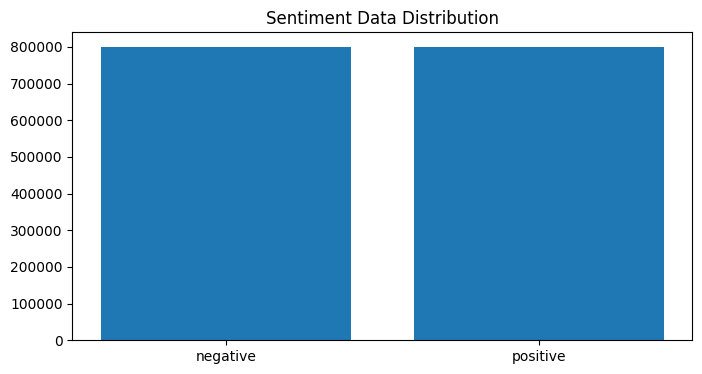

In [8]:
import matplotlib.pyplot as plt

val_count = df.sentiment_label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [64]:
import re
import torch
import numpy as np
from scipy.special import softmax

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
# import time

from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
configr = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

def transform_text(text):
    text = text.lower()  # Normalize case
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'([A-Za-z])\1{2,}', r'\1\1', text)  # Replace repeated characters
    text = re.sub(r'@\S+', '@user', text)  # Replace user mentions
    text = re.sub(r'#', '', text)  # Optional: Remove the hashtag symbol, keep the word
    text = re.sub(r'[^a-z0-9 ]+', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

def roberta(text, tokenizer, model, configr):
    ptext = transform_text(text)
    
    input = tokenizer(ptext, return_tensors='pt')
    input = input.to(device)
    
    with torch.no_grad():
        output = model(**input)
        
    scores = output[0][0].cpu().detach().numpy()
    scores = softmax(scores)
    
    sentiment_score = scores[2].item() - scores[0].item()
    max_score = np.argmax(scores)
    label = configr.id2label[max_score]
    
    return label, sentiment_score

In [10]:
import random

random.seed(69)

random_idx_list = [random.randint(1,len(df.text)) for i in range(2000)] # creates random indexes to choose from dataframe
df0 = df.loc[random_idx_list,:]

In [11]:
counter = 0

def process_text(x):
    label, score = roberta(x, tokenizer, model, configr)
    if label == 'neutral':
        return pd.Series([None, None])
    else:
        global counter
        counter += 1
        print(f'Processed {counter}/{len(df)} texts', end='\r')
        return pd.Series([label, score])

df0[['roberta_label', 'roberta_score']] = df0.text.apply(process_text)
df0 = df0.dropna(subset=['roberta_label'])

In [12]:
print(len(df0))
df0.head()

1092


,sentiment_label,text,roberta_label,roberta_score
78234,negative,@DJSMOOK is everyone still there? Am I still a...,negative,-0.556635
350046,negative,i watched the finale of life with derek. i fee...,negative,-0.366377
139830,negative,Life... YOU SUCK!,negative,-0.861138
869339,positive,Had so much fun singstaring! Thanks Leah,positive,0.898155
898308,positive,@daNanner that is great site us us that still ...,positive,0.777681


In [13]:
from sklearn.metrics import precision_score

true_labels = list(df0.sentiment_label.values)
predicted_labels = list(df0.roberta_label.values)

classes = ['positive', 'neutral', 'negative']

precision_scores = precision_score(true_labels, predicted_labels, labels=classes, average=None)

precision_dict = dict(zip(classes, precision_scores))

print(f'Precision for each class: {precision_dict}')

Precision for each class: {'positive': 0.8008948545861297, 'neutral': 0.0, 'negative': 0.7984496124031008}


/Users/master/anaconda3/envs/jbg030/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Define functions for preprocessing
def preprocess_text(text):
    text = text.lower()
    
    # Tokenize
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    processed_text = ' '.join(lemmatized_words)
    return processed_text

import concurrent.futures

def parallel_preprocess(data):
    with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
        processed_data = list(executor.map(preprocess_text, data))
    return processed_data

[nltk_data] Downloading package wordnet to /Users/master/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [93]:
import nltk 
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

def roberta_stemmed(text, tokenizer, model, configr):
    ptext = preprocess_text(text)
    
    input = tokenizer(ptext, return_tensors='pt')
    input = input.to(device)
    
    with torch.no_grad():
        output = model(**input)
        
    scores = output[0][0].cpu().detach().numpy()
    scores = softmax(scores)
    
    sentiment_score = scores[2].item() - scores[0].item()
    max_score = np.argmax(scores)
    label = configr.id2label[max_score]
    
    return label, sentiment_score

In [94]:
random.seed(69)

random_idx_list1 = [random.randint(1,len(df.text)) for i in range(2000)] # creates random indexes to choose from dataframe
df1 = df.loc[random_idx_list1,:]

In [95]:
counter1 = 0

def process_text_stemmed(x):
    label, score = roberta_stemmed(x, tokenizer, model, configr)
    if label == 'neutral':
        return pd.Series([None, None])
    else:
        global counter1
        counter1 += 1
        print(f'Processed {counter1}/{len(df)} texts', end='\r')
        return pd.Series([label, score])

df1[['roberta_label', 'roberta_score']] = df1.text.apply(process_text_stemmed)
df1 = df1.dropna(subset=['roberta_label'])

In [96]:
print(len(df1))
df1.head()

1040


,sentiment_label,text,roberta_label,roberta_score
78234,negative,@DJSMOOK is everyone still there? Am I still a...,negative,-0.892945
350046,negative,i watched the finale of life with derek. i fee...,negative,-0.679009
139830,negative,Life... YOU SUCK!,negative,-0.915433
1269037,positive,Freebie: Head to On The Border restaurants for...,positive,0.532857
869339,positive,Had so much fun singstaring! Thanks Leah,positive,0.983781


In [97]:
from sklearn.metrics import precision_score

true_labels = list(df1.sentiment_label.values)
predicted_labels = list(df1.roberta_label.values)

classes = ['positive', 'neutral', 'negative']

precision_scores = precision_score(true_labels, predicted_labels, labels=classes, average=None)

precision_dict = dict(zip(classes, precision_scores))

print(f'Precision for each class: {precision_dict}')

Precision for each class: {'positive': 0.7768166089965398, 'neutral': 0.0, 'negative': 0.841991341991342}


/Users/master/anaconda3/envs/jbg030/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
